# Deep Reinforcement Learning for Optimal Execution of Portfolio Transactions     

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random

import syntheticChrissAlmgren as sca_cont
import syntheticChrissAlmgren_discrete as sca_disc

from collections import deque, namedtuple

# Get the default financial and AC Model parameters
plt.style.use('seaborn')


In [3]:
import math
import random
from time import time
import gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical

from IPython.display import clear_output
import matplotlib.pyplot as plt


# Use CUDA
use_cuda = torch.cuda.is_available()
device   = torch.device("cuda" if use_cuda else "cpu")


# Create Environments
import sys  

# A2C

In [39]:
#based on https://github.com/lucifer2859/Policy-Gradients/blob/master/actor-critic.py
#Discrete
class ActorCritic(nn.Module):
    def __init__(self, num_inputs, num_outputs, hidden_size1, hidden_size2, std=0.0):
        super(ActorCritic, self).__init__()
        
        self.critic = nn.Sequential(
            nn.Linear(num_inputs, hidden_size1),
            nn.LeakyReLU(),
            nn.Linear(hidden_size1, hidden_size2),
            nn.LeakyReLU(),
            nn.Linear(hidden_size2, 1)
        )
        
        self.actor = nn.Sequential(
            nn.Linear(num_inputs, hidden_size1),
            nn.LeakyReLU(),
            nn.Linear(hidden_size1, hidden_size2),
            nn.LeakyReLU(),
            nn.Linear(hidden_size2, num_outputs),
            nn.Softmax(dim=-1),
        )
        
    def forward(self, x):
        value = self.critic(x)
        probs = self.actor(x)
        dist  = Categorical(probs)
        return dist, value

class TargetCritic(nn.Module):
    def __init__(self, num_inputs, num_outputs, hidden_size1, hidden_size2, std=0.0):
        super(ActorCritic, self).__init__()
        
        self.critic = nn.Sequential(
            nn.Linear(num_inputs, hidden_size1),
            nn.LeakyReLU(),
            nn.Linear(hidden_size1, hidden_size2),
            nn.LeakyReLU(),
            nn.Linear(hidden_size2, 1)
        )
        
    def forward(self, x):
        value = self.critic(x)
        return value



def plot(frame_idx, rewards):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, rewards[-1]))
    plt.plot(rewards)
    plt.show()
    
def test_env():
    state = env.reset()
    done = False
    total_reward = 0
    while not done:
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        dist, _ = model(state)
        next_state, reward, done, _ = env.step(dist.sample().cpu().numpy()[0] / 100)
        state = next_state
        total_reward += reward
    return total_reward

def compute_returns(next_value, rewards, masks, gamma=0.99):
    R = next_value
    returns = []
    for step in reversed(range(len(rewards))):
        R = rewards[step] + gamma * R * masks[step]
        returns.insert(0, R)
    return returns


In [40]:
# Set the liquidation time
lqt = 100
# Set the number of trades
n_trades = 60
# Set trader's risk aversion
tr1 = 1e-6

episodes = 2000

Episode [0/2000]	Average Shortfall for Agent1: $221,178.65

Average Implementation Shortfall for Agent1: $221,178.65 

Episode [10/2000]	Average Shortfall for Agent1: $282,440.45

Average Implementation Shortfall for Agent1: $282,440.45 

Episode [20/2000]	Average Shortfall for Agent1: $287,753.52

Average Implementation Shortfall for Agent1: $287,753.52 

Episode [30/2000]	Average Shortfall for Agent1: $297,637.92

Average Implementation Shortfall for Agent1: $297,637.92 

Episode [40/2000]	Average Shortfall for Agent1: $298,027.31

Average Implementation Shortfall for Agent1: $298,027.31 

Episode [50/2000]	Average Shortfall for Agent1: $287,884.84

Average Implementation Shortfall for Agent1: $287,884.84 

Episode [60/2000]	Average Shortfall for Agent1: $279,862.77

Average Implementation Shortfall for Agent1: $279,862.77 

Episode [70/2000]	Average Shortfall for Agent1: $273,236.70

Average Implementation Shortfall for Agent1: $273,236.70 

Episode [80/2000]	Average Shortfall for A

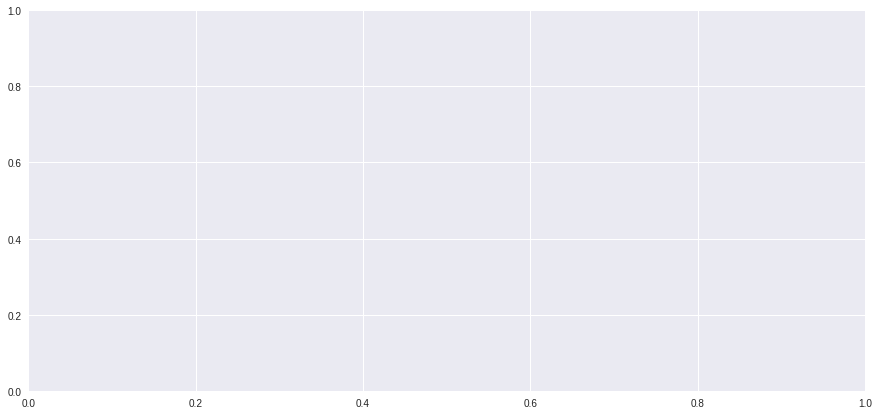

In [41]:
env = sca_disc.MarketEnvironment()
num_inputs  = env.observation_space_dimension()
num_outputs = env.action_space_dimension()

# Hyper params:
hidden_size = 256
lr          = 3e-4
num_steps   = 5

model = ActorCritic(num_inputs, num_outputs, hidden_size1 = 128, hidden_size2 = 256).to(device)
optimizer = optim.Adam(model.parameters())

#model_target = TargetCritic(num_inputs, num_outputs, hidden_size1 = 128, hidden_size2 = 256).to(device)
#optimizer_target = optim.Adam(model_target.parameters())

max_frames   = 3000

shortfall_list = []
shortfall_hist1 = np.array([])
shortfall_deque1 = deque(maxlen=10000)
reward_list = []

fig = plt.figure(figsize = (15, 7))
ax = fig.add_subplot(1, 1, 1) 

for episode in range(episodes): 
    log_probs = []
    values    = []
    rewards   = []
    masks     = []
    entropy = 0
    state = env.reset(seed = episode, liquid_time = lqt, num_trades = n_trades, lamb1 = tr1)
    env.start_transactions()

    for i in range(n_trades + 1):
        state = torch.FloatTensor(state).to(device)
        dist, value = model(state)
        action = dist.sample()
        next_state, reward, done, info = env.step(action.cpu().numpy()/100)
        log_prob = dist.log_prob(action)
        entropy += dist.entropy().mean()
        
        log_probs.append(log_prob)
        values.append(value)
        rewards.append(torch.tensor(reward).float().to(device))
        masks.append(torch.tensor(1 - done).float().to(device))
        
        state = next_state
        i += 1
        
        if info.done1:
            shortfall_hist1 = np.append(shortfall_hist1, info.implementation_shortfall1)
            shortfall_deque1.append(info.implementation_shortfall1)
            break
        #if frame_idx % 100 == 0:
        #    test_rewards.append(np.mean([test_env() for _ in range(1)]))
        #   # plot(frame_idx, test_rewards)
         #   print('Frame: %d, Reward: %.2f' % (frame_idx, test_rewards[-1]))

    reward_list.append(np.mean([l.numpy() for l in rewards]))        
    next_state = torch.FloatTensor(next_state).to(device)
    _, next_value = model(next_state)
    returns = compute_returns(next_value, rewards, masks)
    
    log_probs = torch.stack(log_probs)
    returns   = torch.stack(returns).detach()
    values    = torch.stack(values)

    advantage = returns - values

    actor_loss  = - (log_probs * advantage.detach()).mean()
    critic_loss = advantage.pow(2).mean()

    loss = actor_loss + 0.5 * critic_loss - 0.001 * entropy

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    #ax.set_xlim(0, i)    
    #ax.cla()
    #ax.plot(reward_list)
    #display(fig)    
    #clear_output(wait = True)
    #plt.pause(0.1)

    if episode % 10 == 0: # print average shortfall over last 100 episodes
        print('\rEpisode [{}/{}]\tAverage Shortfall for Agent1: ${:,.2f}'.format(episode, episodes, np.mean(shortfall_deque1)))        
        shortfall_list.append([np.mean(shortfall_deque1)])
        print('\nAverage Implementation Shortfall for Agent1: ${:,.2f} \n'.format(np.mean(shortfall_hist1)))

shortfall_a2c_vanilla = np.array(shortfall_list)

In [17]:
AC_shortfall_expected = env.get_AC_expected_shortfall(env.total_shares1, env.kappa1)

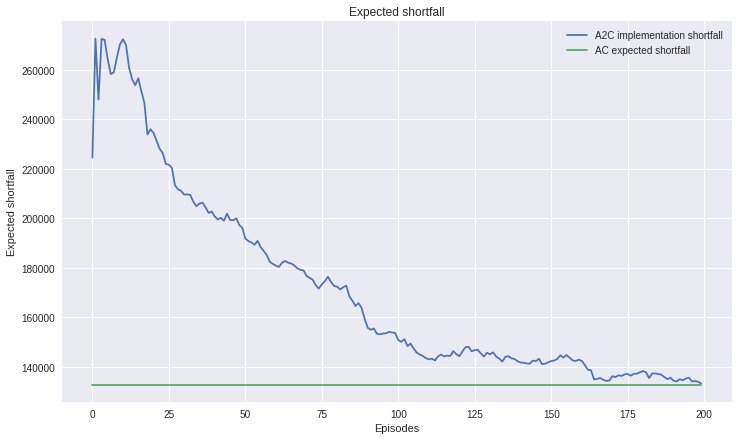

In [18]:
plt.figure(figsize = (12, 7))
plt.plot(shortfall_a2c_vanilla, label = 'A2C implementation shortfall')
#plt.plot(shortfall_ac, label = 'AC implementation shortfall')
plt.plot(np.repeat(AC_shortfall_expected, len(shortfall_a2c_vanilla)), label = 'AC expected shortfall')
plt.xlabel('Episodes')
plt.ylabel('Expected shortfall')
plt.legend()
plt.title('Expected shortfall');

In [43]:
state = env.reset(seed = episode, liquid_time = lqt, num_trades = n_trades, lamb1 = tr1)
env.start_transactions()
trajectory_a2c = np.zeros([n_trades + 1])

for i in range(n_trades + 1):
        trajectory_a2c[i] = state[-1]
        state = torch.FloatTensor(state).to(device)
        dist, value = model(state)
        action = dist.sample()
        next_state, reward, done, info = env.step(action.cpu().numpy()/100)
        state = next_state  


#SAC

In [44]:
from SAC import Agent

In [46]:
#https://github.com/BY571/Soft-Actor-Critic-and-Extensions
seed = 1
n_episodes = episodes
GAMMA = 0.99
TAU = 1e-2
HIDDEN_SIZE = 256
BUFFER_SIZE = int(10000)
BATCH_SIZE = 64        # minibatch size
LR_ACTOR = 5e-4        # learning rate of the actor 
LR_CRITIC = 5e-4        # learning rate of the critic
#FIXED_ALPHA = args.alpha
#saved_model = args.saved_model

#writer = SummaryWriter("runs/"+args.info)

env = sca_cont.MarketEnvironment()

action_high = 1
action_low = 1e-8
torch.manual_seed(seed)
np.random.seed(seed)
state_size = env.observation_space_dimension()
action_size = env.action_space_dimension()
agent = Agent(state_size=state_size, action_size=action_size, random_seed=seed,hidden_size=HIDDEN_SIZE, action_prior="uniform") #"normal"

scores_deque = deque(maxlen=1000)
#average_100_scores = []

shortfall_list = []
shortfall_hist1 = np.array([])
shortfall_deque1 = deque(maxlen=10000)
reward_list = []

for episode in range(episodes):
    state = env.reset(seed = episode, liquid_time = lqt, num_trades = n_trades, lamb1 = tr1)
    env.start_transactions()
    state = state.reshape((1,state_size))
    score = 0
    for t in range(n_trades + 1):
        action = agent.act(state)
        action_v = action.numpy()
        action_v = np.clip(action_v*action_high, action_low, action_high)
        next_state, reward, done, info = env.step(action_v)
        next_state = next_state.reshape((1,state_size))
        agent.step(state, action, reward, next_state, done, t)
        state = next_state
        score += reward

        if info.done1:
            shortfall_hist1 = np.append(shortfall_hist1, info.implementation_shortfall1)
            shortfall_deque1.append(info.implementation_shortfall1)
            break 

    if episode % 10 == 0: # print average shortfall over last 100 episodes
        print('\rEpisode [{}/{}]\tAverage Shortfall for Agent1: ${:,.2f}'.format(episode, episodes, np.mean(shortfall_deque1)))        
        shortfall_list.append([np.mean(shortfall_deque1)])
        print('\nAverage Implementation Shortfall for Agent1: ${:,.2f} \n'.format(np.mean(shortfall_hist1)))

shortfall_sac_cont = np.array(shortfall_list)

Episode [0/2000]	Average Shortfall for Agent1: $366,013.19

Average Implementation Shortfall for Agent1: $366,013.19 

Episode [10/2000]	Average Shortfall for Agent1: $550,008.98

Average Implementation Shortfall for Agent1: $550,008.98 

Episode [20/2000]	Average Shortfall for Agent1: $392,636.40

Average Implementation Shortfall for Agent1: $392,636.40 

Episode [30/2000]	Average Shortfall for Agent1: $500,437.68

Average Implementation Shortfall for Agent1: $500,437.68 

Episode [40/2000]	Average Shortfall for Agent1: $479,872.58

Average Implementation Shortfall for Agent1: $479,872.58 

Episode [50/2000]	Average Shortfall for Agent1: $394,346.24

Average Implementation Shortfall for Agent1: $394,346.24 

Episode [60/2000]	Average Shortfall for Agent1: $354,585.04

Average Implementation Shortfall for Agent1: $354,585.04 

Episode [70/2000]	Average Shortfall for Agent1: $320,250.20

Average Implementation Shortfall for Agent1: $320,250.20 

Episode [80/2000]	Average Shortfall for A

In [50]:
state = env.reset(seed = episode, liquid_time = lqt, num_trades = n_trades, lamb1 = tr1)
env.start_transactions()
state = state.reshape((1,state_size))
trajectory_sac_cont = np.zeros([n_trades + 1])

for t in range(n_trades + 1):
    trajectory_sac_cont[t] = state[0][-1]
    action = agent.act(state)
    action_v = action.numpy()
    action_v = np.clip(action_v*action_high, action_low, action_high)
    next_state, reward, done, info = env.step(action_v)
    next_state = next_state.reshape((1,state_size))
    #agent.step(state, action, reward, next_state, done, t)
    state = next_state

In [51]:
#https://github.com/BY571/SAC_discrete

import gym
import numpy as np
from collections import deque
import torch
from buffer import ReplayBuffer
import glob
from utils import save, collect_random
import random
from agent import SAC


np.random.seed(1)
random.seed(1)
torch.manual_seed(1)
env = sca_disc.MarketEnvironment()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

steps = 0
average10 = deque(maxlen=10)
total_steps = 0
    

agent = SAC(state_size=env.observation_space_dimension(), action_size=env.action_space_dimension(), device=device)

buffer = ReplayBuffer(buffer_size=10000, batch_size=64, device=device)

collect_random(env=env, dataset=buffer, num_samples=10000)

shortfall_list = []
shortfall_hist1 = np.array([])
shortfall_deque1 = deque(maxlen=10000)
reward_list = []

for episode in range(episodes):
  state = state = env.reset(seed = episode, liquid_time = lqt, num_trades = n_trades, lamb1 = tr1)
  env.start_transactions()
  episode_steps = 0
  rewards = 0
  for s in range(n_trades + 1):
      action = agent.get_action(state)
      steps += 1
      next_state, reward, done, info = env.step(action/100)
      buffer.add(state, action, reward, next_state, done)
      policy_loss, alpha_loss, bellmann_error1, bellmann_error2, current_alpha = agent.learn(steps, buffer.sample(), gamma=0.99)
      state = next_state
      rewards += reward
      episode_steps += 1
      if info.done1:
            shortfall_hist1 = np.append(shortfall_hist1, info.implementation_shortfall1)
            shortfall_deque1.append(info.implementation_shortfall1)
            break 

  if episode % 10 == 0: # print average shortfall over last 100 episodes
        print('\rEpisode [{}/{}]\tAverage Shortfall for Agent1: ${:,.2f}'.format(episode, episodes, np.mean(shortfall_deque1)))        
        shortfall_list.append([np.mean(shortfall_deque1)])
        print('\nAverage Implementation Shortfall for Agent1: ${:,.2f} \n'.format(np.mean(shortfall_hist1)))

shortfall_sac_disc = np.array(shortfall_list)

Episode [0/2000]	Average Shortfall for Agent1: $137,613.15

Average Implementation Shortfall for Agent1: $137,613.15 

Episode [10/2000]	Average Shortfall for Agent1: $266,025.61

Average Implementation Shortfall for Agent1: $266,025.61 

Episode [20/2000]	Average Shortfall for Agent1: $264,081.24

Average Implementation Shortfall for Agent1: $264,081.24 

Episode [30/2000]	Average Shortfall for Agent1: $244,401.04

Average Implementation Shortfall for Agent1: $244,401.04 

Episode [40/2000]	Average Shortfall for Agent1: $228,807.22

Average Implementation Shortfall for Agent1: $228,807.22 

Episode [50/2000]	Average Shortfall for Agent1: $207,287.62

Average Implementation Shortfall for Agent1: $207,287.62 

Episode [60/2000]	Average Shortfall for Agent1: $204,836.69

Average Implementation Shortfall for Agent1: $204,836.69 

Episode [70/2000]	Average Shortfall for Agent1: $213,049.89

Average Implementation Shortfall for Agent1: $213,049.89 

Episode [80/2000]	Average Shortfall for A

In [54]:
state = state = env.reset(seed = episode, liquid_time = lqt, num_trades = n_trades, lamb1 = tr1)
env.start_transactions()
trajectory_sac_disc = np.zeros([n_trades + 1])
    
for s in range(n_trades + 1):
    trajectory_sac_disc[s] = state[-1]
    action = agent.get_action(state)
    next_state, reward, done, info = env.step(action/100)
    buffer.add(state, action, reward, next_state, done)
    state = next_state
    

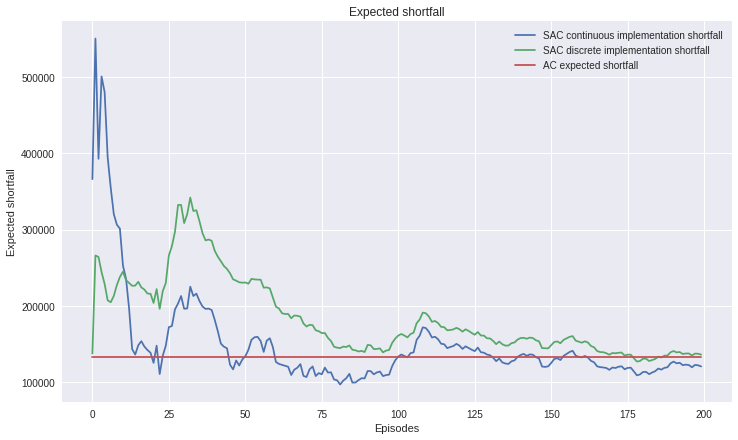

In [22]:
plt.figure(figsize = (12, 7))
plt.plot(shortfall_sac_cont, label = 'SAC continuous implementation shortfall')
plt.plot(shortfall_sac_disc, label = 'SAC discrete implementation shortfall')
plt.plot(np.repeat(AC_shortfall_expected, len(shortfall_sac_cont)), label = 'AC expected shortfall')
plt.xlabel('Episodes')
plt.ylabel('Expected shortfall')
plt.legend()
plt.title('Expected shortfall');

#PPO

In [55]:
#https://github.com/nikhilbarhate99/PPO-PyTorch
from PPO_disc_cont import PPO
import os
import glob
import time
from datetime import datetime

In [65]:

####### initialize environment hyperparameters ######
shortfall_list = []
shortfall_hist1 = np.array([])
shortfall_deque1 = deque(maxlen=10000)
reward_list = []

has_continuous_action_space = False  # continuous action space; else discrete

max_ep_len = n_trades + 1                   # max timesteps in one episode
action_std = 0.6                    # starting std for action distribution (Multivariate Normal)
action_std_decay_rate = 0.05        # linearly decay action_std (action_std = action_std - action_std_decay_rate)
min_action_std = 0.1                # minimum action_std (stop decay after action_std <= min_action_std)
action_std_decay_freq = int(2.5e5)  # action_std decay frequency (in num timesteps)

update_timestep = max_ep_len * 4      # update policy every n timesteps
K_epochs = 80               # update policy for K epochs in one PPO update

eps_clip = 0.2          # clip parameter for PPO
gamma = 0.99            # discount factor

lr_actor = 0.0003       # learning rate for actor network
lr_critic = 0.001       # learning rate for critic network

random_seed = 0         # set random seed if required (0 = no random seed)

env = sca_disc.MarketEnvironment()
num_outputs = env.action_space_dimension()

# state space dimension
state_dim = env.observation_space_dimension()

# action space dimension
if has_continuous_action_space:
    action_dim = env.action_space_dimension()
else:
    action_dim = env.action_space_dimension()

if random_seed:
    torch.manual_seed(random_seed)
    np.random.seed(random_seed)

################# training procedure ################

# initialize a PPO agent
ppo_agent = PPO(state_dim, action_dim, lr_actor, lr_critic, gamma, K_epochs, eps_clip, has_continuous_action_space, action_std)

time_step = 0

# training loop
for episode in range(episodes):

    state = env.reset(seed = episode, liquid_time = lqt, num_trades = n_trades, lamb1 = tr1)
    env.start_transactions()
    #current_ep_reward = 0

    for t in range(1, n_trades+1):

        # select action with policy
        action = ppo_agent.select_action(state)
        state, reward, done, info = env.step(action / 100)
        # saving reward and is_terminals
        ppo_agent.buffer.rewards.append(reward)
        ppo_agent.buffer.is_terminals.append(done)

        time_step +=1
        #current_ep_reward += reward

        # update PPO agent
        if time_step % update_timestep == 0:
            ppo_agent.update()

        # if continuous action space; then decay action std of ouput action distribution
        if has_continuous_action_space and time_step % action_std_decay_freq == 0:
            ppo_agent.decay_action_std(action_std_decay_rate, min_action_std)

        if info.done1:
            shortfall_hist1 = np.append(shortfall_hist1, info.implementation_shortfall1)
            shortfall_deque1.append(info.implementation_shortfall1)
            break

    if episode % 10 == 0: # print average shortfall over last 100 episodes
            print('\rEpisode [{}/{}]\tAverage Shortfall for Agent1: ${:,.2f}'.format(episode, episodes, np.mean(shortfall_deque1)))        
            shortfall_list.append([np.mean(shortfall_deque1)])
            print('\nAverage Implementation Shortfall for Agent1: ${:,.2f} \n'.format(np.mean(shortfall_hist1)))

shortfall_ppo_disc = np.array(shortfall_list)

Episode [0/2000]	Average Shortfall for Agent1: $187,496.38

Average Implementation Shortfall for Agent1: $187,496.38 

Episode [10/2000]	Average Shortfall for Agent1: $278,255.06

Average Implementation Shortfall for Agent1: $278,255.06 

Episode [20/2000]	Average Shortfall for Agent1: $259,281.47

Average Implementation Shortfall for Agent1: $259,281.47 

Episode [30/2000]	Average Shortfall for Agent1: $249,175.07

Average Implementation Shortfall for Agent1: $249,175.07 

Episode [40/2000]	Average Shortfall for Agent1: $245,620.48

Average Implementation Shortfall for Agent1: $245,620.48 

Episode [50/2000]	Average Shortfall for Agent1: $242,410.81

Average Implementation Shortfall for Agent1: $242,410.81 

Episode [60/2000]	Average Shortfall for Agent1: $239,175.10

Average Implementation Shortfall for Agent1: $239,175.10 

Episode [70/2000]	Average Shortfall for Agent1: $240,299.30

Average Implementation Shortfall for Agent1: $240,299.30 

Episode [80/2000]	Average Shortfall for A

In [67]:
state = env.reset(seed = episode, liquid_time = lqt, num_trades = n_trades, lamb1 = tr1)
env.start_transactions()
#current_ep_reward = 0
trajectory_ppo_disc = np.zeros([n_trades + 1])
    
for t in range(n_trades+1):
    trajectory_ppo_disc[t] = state[-1]
    # select action with policy
    action = ppo_agent.select_action(state)
    state, reward, done, info = env.step(action / 100)
    # saving reward and is_terminals
    ppo_agent.buffer.rewards.append(reward)
    ppo_agent.buffer.is_terminals.append(done)
    

In [68]:

####### initialize environment hyperparameters ######
shortfall_list = []
shortfall_hist1 = np.array([])
shortfall_deque1 = deque(maxlen=10000)
reward_list = []

has_continuous_action_space = True  # continuous action space; else discrete

max_ep_len = n_trades + 1                   # max timesteps in one episode
action_std = 0.6                    # starting std for action distribution (Multivariate Normal)
action_std_decay_rate = 0.05        # linearly decay action_std (action_std = action_std - action_std_decay_rate)
min_action_std = 0.1                # minimum action_std (stop decay after action_std <= min_action_std)
action_std_decay_freq = int(2.5e5)  # action_std decay frequency (in num timesteps)

update_timestep = max_ep_len * 4      # update policy every n timesteps
K_epochs = 80               # update policy for K epochs in one PPO update

eps_clip = 0.2          # clip parameter for PPO
gamma = 0.99            # discount factor

lr_actor = 0.0003       # learning rate for actor network
lr_critic = 0.001       # learning rate for critic network

random_seed = 0         # set random seed if required (0 = no random seed)

env = sca_cont.MarketEnvironment()
num_outputs = env.action_space_dimension()

# state space dimension
state_dim = env.observation_space_dimension()

# action space dimension
if has_continuous_action_space:
    action_dim = env.action_space_dimension()
else:
    action_dim = env.action_space_dimension()

if random_seed:
    torch.manual_seed(random_seed)
    np.random.seed(random_seed)

################# training procedure ################

# initialize a PPO agent
ppo_agent = PPO(state_dim, action_dim, lr_actor, lr_critic, gamma, K_epochs, eps_clip, has_continuous_action_space, action_std)

time_step = 0

# training loop
for episode in range(episodes):

    state = env.reset(seed = episode, liquid_time = lqt, num_trades = n_trades, lamb1 = tr1)
    env.start_transactions()
    #current_ep_reward = 0

    for t in range(1, n_trades+1):

        # select action with policy
        action = ppo_agent.select_action(state)
        state, reward, done, info = env.step(action) #can be negative
        # saving reward and is_terminals
        ppo_agent.buffer.rewards.append(reward)
        ppo_agent.buffer.is_terminals.append(done)

        time_step +=1
        #current_ep_reward += reward

        # update PPO agent
        if time_step % update_timestep == 0:
            ppo_agent.update()

        # if continuous action space; then decay action std of ouput action distribution
        if has_continuous_action_space and time_step % action_std_decay_freq == 0:
            ppo_agent.decay_action_std(action_std_decay_rate, min_action_std)

        if info.done1:
            shortfall_hist1 = np.append(shortfall_hist1, info.implementation_shortfall1)
            shortfall_deque1.append(info.implementation_shortfall1)
            break

    if episode % 10 == 0: # print average shortfall over last 100 episodes
            print('\rEpisode [{}/{}]\tAverage Shortfall for Agent1: ${:,.2f}'.format(episode, episodes, np.mean(shortfall_deque1)))        
            shortfall_list.append([np.mean(shortfall_deque1)])
            print('\nAverage Implementation Shortfall for Agent1: ${:,.2f} \n'.format(np.mean(shortfall_hist1)))

shortfall_ppo_cont = np.array(shortfall_list)

Episode [0/2000]	Average Shortfall for Agent1: $213,713.25

Average Implementation Shortfall for Agent1: $213,713.25 

Episode [10/2000]	Average Shortfall for Agent1: $243,341.61

Average Implementation Shortfall for Agent1: $243,341.61 

Episode [20/2000]	Average Shortfall for Agent1: $237,864.88

Average Implementation Shortfall for Agent1: $237,864.88 

Episode [30/2000]	Average Shortfall for Agent1: $259,355.12

Average Implementation Shortfall for Agent1: $259,355.12 

Episode [40/2000]	Average Shortfall for Agent1: $253,937.09

Average Implementation Shortfall for Agent1: $253,937.09 

Episode [50/2000]	Average Shortfall for Agent1: $261,702.66

Average Implementation Shortfall for Agent1: $261,702.66 

Episode [60/2000]	Average Shortfall for Agent1: $245,062.57

Average Implementation Shortfall for Agent1: $245,062.57 

Episode [70/2000]	Average Shortfall for Agent1: $240,657.81

Average Implementation Shortfall for Agent1: $240,657.81 

Episode [80/2000]	Average Shortfall for A

In [69]:
state = env.reset(seed = episode, liquid_time = lqt, num_trades = n_trades, lamb1 = tr1)
env.start_transactions()
trajectory_ppo_cont = np.zeros([n_trades + 1])
    
    
for t in range(n_trades+1):
    trajectory_ppo_cont[t] = state[-1]
    action = ppo_agent.select_action(state)
    state, reward, done, info = env.step(action) #can be negative
    # saving reward and is_terminals
    ppo_agent.buffer.rewards.append(reward)
    ppo_agent.buffer.is_terminals.append(done)



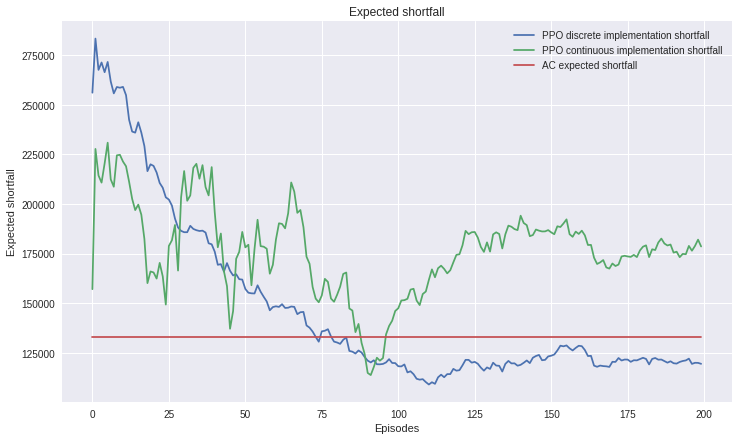

In [26]:
plt.figure(figsize = (12, 7))
plt.plot(shortfall_ppo_disc, label = 'PPO discrete implementation shortfall')
plt.plot(shortfall_ppo_cont, label = 'PPO continuous implementation shortfall')
plt.plot(np.repeat(AC_shortfall_expected, len(shortfall_ppo_disc)), label = 'AC expected shortfall')
plt.xlabel('Episodes')
plt.ylabel('Expected shortfall')
plt.legend()
plt.title('Expected shortfall');

#DDPG

In [60]:
# Create simulation environment
from ddpg_agent import Agent

env = sca_cont.MarketEnvironment()

# Initialize Feed-forward DNNs for Actor and Critic models. 
agent1 = Agent(state_size=env.observation_space_dimension(), action_size=env.action_space_dimension(),random_seed = 1142)

shortfall_list = []
shortfall_hist1 = np.array([])
shortfall_deque1 = deque(maxlen=50000)
#shortfall_ac = []

for episode in range(episodes): 
    # Reset the enviroment
    cur_state1 = env.reset(seed = episode, liquid_time = lqt, num_trades = n_trades, lamb1 = tr1)

    # set the environment to make transactions
    env.start_transactions()

    avg_reward = 0.0
    for i in range(n_trades + 1):
      
        # Predict the best action for the current state. 

        #print(cur_state[5:])
        action1 = agent1.act(cur_state1, add_noise = False)[0]
        #print(action1,action2)
        # Action is performed and new state, reward, info are received.
       # print(env.shares_remaining1 * action1)

        new_state1, reward1, done1, info = env.step(action1)
        avg_reward += reward1
        # current state, action, reward, new state are stored in the experience replay

        agent1.step(cur_state1, action1, reward1, new_state1, done1)
        
      #  print(env.shares_remaining1)
        # roll over new state
        cur_state1 = new_state1

        if info.done1:
            shortfall_hist1 = np.append(shortfall_hist1, info.implementation_shortfall1)
            shortfall_deque1.append(info.implementation_shortfall1)
            #shortfall_ac.append(info.)
            avg_reward /= (n_trades + 1)
           # print('---------------------------------')
            break
        
    if (episode + 1) % 2 == 0: # print average shortfall over last 100 episodes
        print('\rEpisode [{}/{}]\tAverage Shortfall for Agent1: ${:,.2f}, average reward {}'.format(episode + 1, episodes, np.mean(shortfall_deque1), avg_reward))        
        shortfall_list.append([np.mean(shortfall_deque1)])
print('\nAverage Implementation Shortfall for Agent1: ${:,.2f} \n'.format(np.mean(shortfall_hist1)))
shortfall_rl = np.array(shortfall_list)

Episode [2/2000]	Average Shortfall for Agent1: $149,210.53, average reward -0.2923707908000007
Episode [4/2000]	Average Shortfall for Agent1: $138,345.92, average reward -0.2923707908000007
Episode [6/2000]	Average Shortfall for Agent1: $168,687.07, average reward -0.2923707908000007
Episode [8/2000]	Average Shortfall for Agent1: $187,311.56, average reward -0.2923707908000007
Episode [10/2000]	Average Shortfall for Agent1: $198,299.35, average reward -0.2893152259950808
Episode [12/2000]	Average Shortfall for Agent1: $182,041.09, average reward -0.2833500089442632
Episode [14/2000]	Average Shortfall for Agent1: $185,153.24, average reward -0.2743125540327871
Episode [16/2000]	Average Shortfall for Agent1: $184,970.18, average reward -0.26385776943278677
Episode [18/2000]	Average Shortfall for Agent1: $176,712.13, average reward -0.25412438089016315
Episode [20/2000]	Average Shortfall for Agent1: $170,736.83, average reward -0.25465179055409765
Episode [22/2000]	Average Shortfall for A

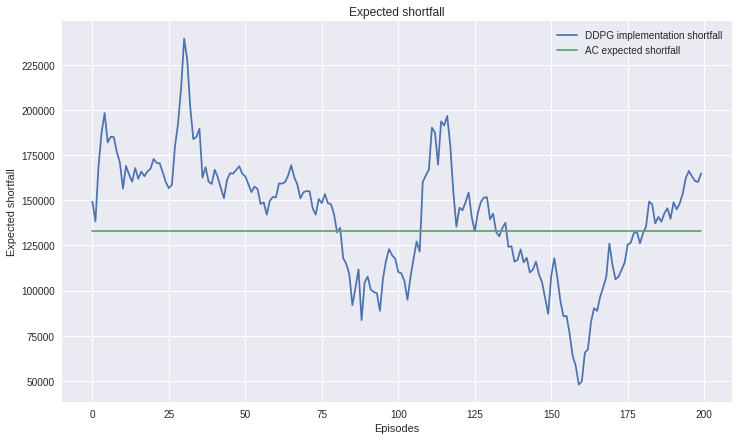

In [33]:
plt.figure(figsize = (12, 7))
plt.plot(shortfall_rl[:200], label = 'DDPG implementation shortfall')
plt.plot(np.repeat(AC_shortfall_expected, len(shortfall_ppo_disc)), label = 'AC expected shortfall')
plt.xlabel('Episodes')
plt.ylabel('Expected shortfall')
plt.legend()
plt.title('Expected shortfall');

In [61]:
cur_state1 = env.reset(seed = episode, liquid_time = lqt, num_trades = n_trades, lamb1 = tr1)

env.start_transactions()

trajectory_ddpg = np.zeros([n_trades + 1])
trajectory_ac = np.zeros([n_trades + 1])

for i in range(n_trades + 1):
    trajectory_ddpg[i] = cur_state1[-1]
    trajectory_ac[i] = (np.sinh(env.kappa1*(lqt - i)) / np.sinh(env.kappa1 * lqt) * env.total_shares1) / env.total_shares1
    action1 = agent1.act(cur_state1, add_noise = True)
    new_state1, reward1, done1, info = env.step(action1)
    #agent1.step(cur_state1, action1, reward1, new_state1, done1)
    cur_state1 = new_state1


# Shortfall dynamics comparison

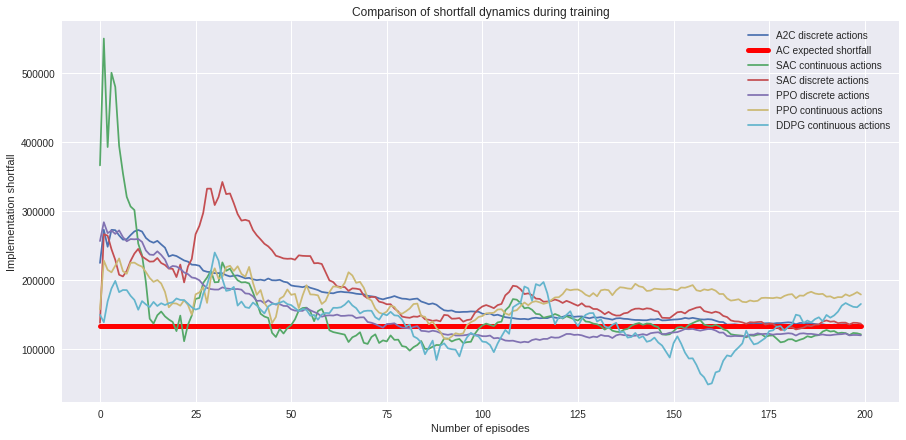

In [36]:
plt.figure(figsize=(15,7))
plt.plot(shortfall_a2c_vanilla, label = 'A2C discrete actions')
plt.plot(np.repeat(AC_shortfall_expected, len(shortfall_ppo_disc)), label = 'AC expected shortfall', linewidth = 5, c = 'red')
plt.plot(shortfall_sac_cont, label = 'SAC continuous actions')
plt.plot(shortfall_sac_disc, label = 'SAC discrete actions')
plt.plot(shortfall_ppo_disc, label = 'PPO discrete actions')
plt.plot(shortfall_ppo_cont, label = 'PPO continuous actions')
plt.plot(shortfall_rl[:200], label = 'DDPG continuous actions')
plt.title('Comparison of shortfall dynamics during training')
plt.xlabel('Number of episodes')
plt.ylabel('Implementation shortfall')
plt.legend()
plt.show();

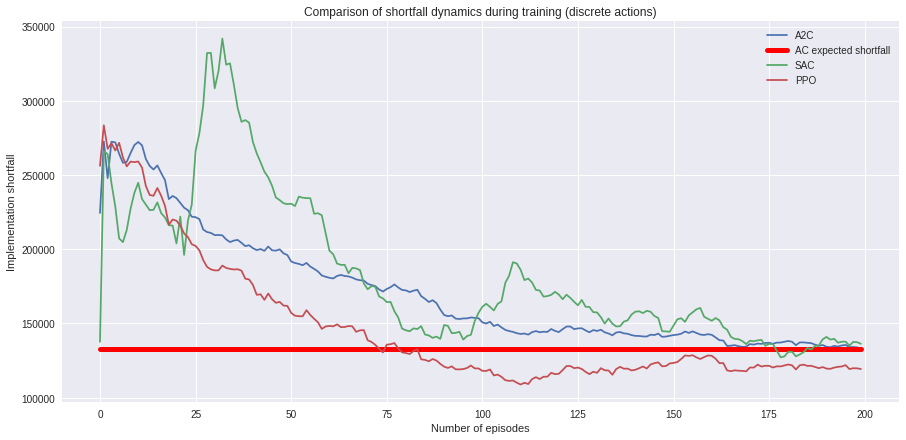

In [37]:
plt.figure(figsize=(15,7))
plt.plot(shortfall_a2c_vanilla, label = 'A2C')
plt.plot(np.repeat(AC_shortfall_expected, len(shortfall_ppo_disc)), label = 'AC expected shortfall', linewidth = 5, c = 'red')
plt.plot(shortfall_sac_disc, label = 'SAC')
plt.plot(shortfall_ppo_disc, label = 'PPO')
plt.title('Comparison of shortfall dynamics during training (discrete actions)')
plt.xlabel('Number of episodes')
plt.ylabel('Implementation shortfall')
plt.legend()
plt.show();

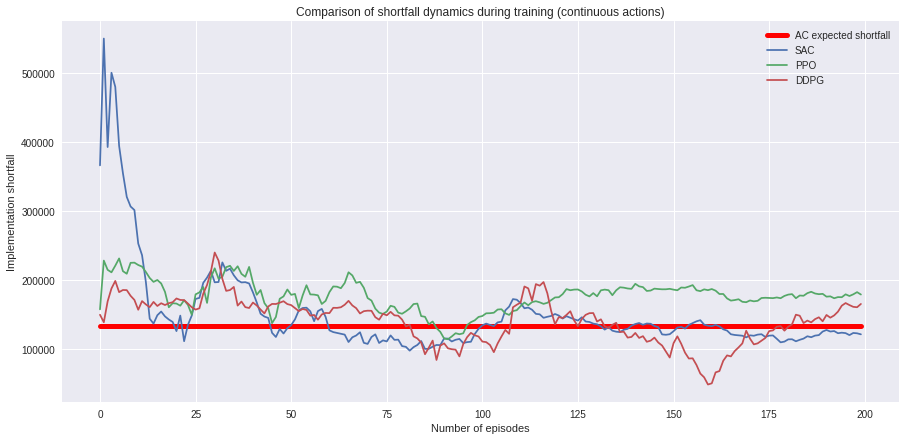

In [38]:
plt.figure(figsize=(15,7))
plt.plot(np.repeat(AC_shortfall_expected, len(shortfall_ppo_disc)), label = 'AC expected shortfall', linewidth = 5, c = 'red')
plt.plot(shortfall_sac_cont, label = 'SAC')
plt.plot(shortfall_ppo_cont, label = 'PPO')
plt.plot(shortfall_rl[:200], label = 'DDPG')
plt.title('Comparison of shortfall dynamics during training (continuous actions)')
plt.xlabel('Number of episodes')
plt.ylabel('Implementation shortfall')
plt.legend()
plt.show();

# Trajectories

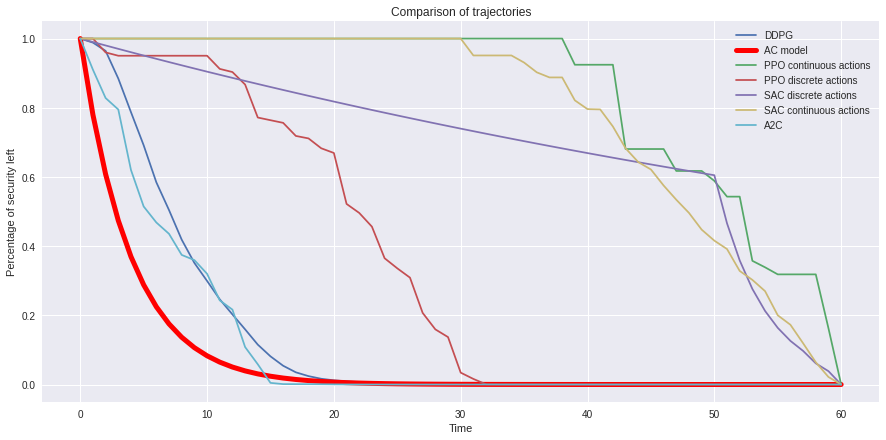

In [70]:
plt.figure(figsize = (15, 7))
plt.plot(trajectory_ddpg, label = 'DDPG')
plt.plot(trajectory_ac, label = 'AC model', linewidth = 5, c = 'red')
plt.plot(trajectory_ppo_cont, label = 'PPO continuous actions')
plt.plot(trajectory_ppo_disc, label = 'PPO discrete actions')
plt.plot(trajectory_sac_disc, label = 'SAC discrete actions')
plt.plot(trajectory_sac_cont, label = 'SAC continuous actions')
plt.plot(trajectory_a2c, label = 'A2C')
plt.xlabel('Time')
plt.ylabel('Percentage of security left')
plt.title('Comparison of trajectories')
plt.legend()
plt.show();